In [1]:
import os
import pandas as pd
path = "/Users/anastasia/Documents/Python"
os.chdir(path)



In [2]:
#Данные
df = pd.read_csv('/Users/anastasia/Downloads/compressed_data.csv', sep=';')
df = df[1:10]
df

,SKU,Item combination ID,Name,Category,Brand,Seller,Color,Balance,Comments,Final price,...,Unnamed: 80,Unnamed: 81,Unnamed: 82,Unnamed: 83,Unnamed: 84,Unnamed: 85,Unnamed: 86,Unnamed: 87,Unnamed: 88,Unnamed: 89
1,149575719,126693294,Носки капроновые телесные набор 10 пар,Акции/Распродажа 11.11/Женщинам/Белье/Колготки...,NIKII,ИП Адюшкин Н Р,светло-бежевый,286,18759,136,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,266510489,244669663,Кроссовки зимние,NaN,Thomas Mitchell,ИП Нестеров И А,"красный, черный",17,26,5876,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,266508481,245279769,Кроссовки зимние,NaN,Thomas Mitchell,ИП Нестеров И А,"зеленый, серый, бежевый, синий",75,24,6247,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,179066374,163341676,кроссовки,NaN,Trendy Feet,Trendy Feet,бело-синий,21,98,3360,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,201392334,182598418,LITE Полуботинки женские осень натуральная кож...,Акции/Распродажа 11.11/Обувь/Женская/Ботинки и...,Mascotte,ООО Радость,"желтый, горчичный, желто-оранжевый",24,487,3179,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,271353738,155081746,Туфли классические кожаные броги,Акции/Распродажа 11.11/Обувь/Мужская/Ботинки и...,Mascotte,ООО Радость,"темно-коричневый, коричневый, темный горький ш...",70,62,7850,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,217831686,154017289,Кроссовки на шнурках,Акции/Распродажа 11.11/Обувь/Детская/Для мальч...,PlayToday,АО Плэйтудэй СНГ,"серый, зеленый, желтый",41,839,1276,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,212290794,191730754,Лоферы женские замшевые,NaN,Ausgut,ИП Ходырев А Г,изумрудно-зеленый,48,91,4905,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,207442697,187808846,Кроссовки Etonic Fanes,Акции/Распродажа 11.11/Спорт/Бег/Ходьба/Бег/Об...,Etonic,ООО Спортмастер,"розовый, фуксия",56,18,3336,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Яркость, Контрастность, Человек, Энтропия

In [3]:
#Обработка на граф фичи базовые
import requests
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import warnings
from urllib3.exceptions import InsecureRequestWarning
from urllib.request import urlopen
import matplotlib.pyplot as plt
from ultralytics import YOLO
from scipy.fftpack import fft2, ifft2

# Отключение предупреждений InsecureRequestWarning
warnings.simplefilter('ignore', InsecureRequestWarning)

def analyze_image(url):
    response = requests.get(url, verify=False)
    img_array = np.frombuffer(response.content, dtype=np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    
    # HSL
    img_hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    h, l, s = cv2.split(img_hls)
    h_mean = np.mean(h)
    s_mean = np.mean(s)
    l_mean = np.mean(l)

    # HSV
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(img_hsv) 
    h_mean = np.mean(h)
    s_mean = np.mean(s)
    v_mean = np.mean(v) 
    
    # Contrast
    l_min = np.min(l)
    l_max = np.max(l)
    l_normalized = (l - l_min) / (l_max - l_min)
    contrast = np.std(l_normalized)
    
    # Person detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    person_probability = int(len(faces) > 0)

    #Энтропия
    image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  
    
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist = hist.ravel() / hist.sum()
    hist = hist[hist != 0]

    entropy_value = -np.sum(hist * np.log2(hist))
    
    return [h_mean, v_mean, l_mean, contrast, person_probability, entropy_value]

urls = df['Thumb'].tolist()

results = []
for url in tqdm(urls, desc="Processing images"):
    try:
        metrics = analyze_image(url)
        results.append([url] + metrics)
    except Exception as e:
        print(f"Error processing {url}: {str(e)}")
        results.append([url] + [None] * 5)  # Добавить пустые значения для неудачных изображений

result_df = pd.DataFrame(results, columns=['Thumb', 'H_mean','Brightness', 'L_mean', 'Contrast', 'Person_probability',
                                            'Entropy_value'])

Processing images: 100%|██████████████████████████| 9/9 [00:03<00:00,  2.70it/s]


## Цветовая гамма

In [4]:
#Цветовая гамма
result_df['Temp_cool'] = result_df['H_mean'].apply(lambda x: 1 if 90 <= x <= 270 else 0)
result = result_df[['Thumb', 'Brightness', 'L_mean', 'Contrast', 'Person_probability',
                    'Entropy_value','Temp_cool']]
result.drop_duplicates(inplace=True)
result

/var/folders/4l/h77mjd0979l8xgdkw8mttfjm0000gn/T/ipykernel_1231/2614486093.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result.drop_duplicates(inplace=True)


,Thumb,Brightness,L_mean,Contrast,Person_probability,Entropy_value,Temp_cool
0,https://basket-10.wbbasket.ru/vol1495/part1495...,198.144383,181.693833,0.159844,0,7.054539,0
1,https://basket-17.wbbasket.ru/vol2665/part2665...,156.375582,145.214394,0.290165,0,7.665070,0
2,https://basket-17.wbbasket.ru/vol2665/part2665...,171.679395,160.900964,0.252590,0,7.528644,0
3,https://basket-12.wbbasket.ru/vol1790/part1790...,218.526324,215.070023,0.169335,0,4.289389,1
4,https://basket-13.wbbasket.ru/vol2013/part2013...,239.683869,225.270685,0.193085,0,2.577599,0
5,https://basket-17.wbbasket.ru/vol2713/part2713...,218.974829,218.438566,0.277011,0,2.231401,0
6,https://basket-14.wbbasket.ru/vol2178/part2178...,165.017214,157.180188,0.300323,0,6.831378,0
7,https://basket-14.wbbasket.ru/vol2122/part2122...,206.641111,190.986751,0.210521,0,6.702322,0
8,https://basket-14.wbbasket.ru/vol2074/part2074...,218.509518,209.015579,0.162709,0,6.705668,1


## Площадь и правило третей

In [33]:
#Обработка на класс объекта YOLO
import requests
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import warnings
from urllib3.exceptions import InsecureRequestWarning
from urllib.request import urlopen
import matplotlib.pyplot as plt
from ultralytics import YOLO
from scipy.fftpack import fft2, ifft2

# Загружаем все модели в список
models = {
    "yolov8n": YOLO('yolov8n.pt'),
    "yolov8l": YOLO('yolov8l.pt'),
    "yolov8m": YOLO('yolov8m.pt'),
    "yolov8x": YOLO('yolov8x.pt')
} 

def compute_normalized_offsets_to_thirds(image, keypoints):

    height, width = image.shape[:2]

    # Линии третей
    third_x1, third_x2 = width / 3, 2 * width / 3
    third_y1, third_y2 = height / 3, 2 * height / 3

    horizontal_offsets = []
    vertical_offsets = []

    if keypoints is None or len(keypoints) == 0: 
        return 0, 0

    for cx, cy in keypoints: 
        dist_x1 = cx - third_x1
        dist_x2 = cx - third_x2
        horizontal_offset = (dist_x1 if abs(dist_x1) < abs(dist_x2) else dist_x2) / width

        dist_y1 = cy - third_y1
        dist_y2 = cy - third_y2
        vertical_offset = (dist_y1 if abs(dist_y1) < abs(dist_y2) else dist_y2) / height

        horizontal_offsets.append(horizontal_offset)
        vertical_offsets.append(vertical_offset)

    avg_horizontal_offset = np.mean(horizontal_offsets)
    avg_vertical_offset = np.mean(vertical_offsets)

    return avg_horizontal_offset, avg_vertical_offset


def analyze_yolo(url, model):
    try:
        response = requests.get(url, stream=True, verify=False)
        response.raise_for_status()
    except requests.exceptions.RequestException as e:
        print(f"Request failed for {url}: {e}")
        return [], 0, 0  

    img_array = np.frombuffer(response.content, dtype=np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)

    if img is None:
        print(f"Could not decode image from {url}")
        return [], 0, 0

    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = model(image_rgb, verbose=False)

    # Получение размеров изображения
    total_image_area = image_rgb.shape[0] * image_rgb.shape[1]

    area_ratios = []
    keypoints = []

    for result in results:
        boxes = result.boxes.xyxy.cpu().numpy().astype(int)  # Получаем координаты углов
        for x1, y1, x2, y2 in boxes:
            cx = (x1 + x2) / 2  # Вычисляем центр
            cy = (y1 + y2) / 2
            keypoints.append((cx, cy))

            box_area = (x2 - x1) * (y2 - y1)
            area_ratio = box_area / total_image_area
            area_ratios.append(area_ratio)
        
    avg_area = np.mean(area_ratios) if area_ratios else 0

    if keypoints:
        avg_keypoints = np.mean(keypoints, axis=0)
        rot_h, rot_v = compute_normalized_offsets_to_thirds(img, [avg_keypoints])
    else:
        rot_h, rot_v = 0, 0

    return avg_area, rot_h, rot_v


urls = df['Thumb'].tolist()
results = []

for url in tqdm(urls, desc="Processing images"):
    row = {"Thumb": url}
    for model_name, model in models.items():
        try:
            avg_area, rot_h, rot_v = analyze_yolo(url, model)
            row[f"area_{model_name}"] = avg_area  
            row[f"rot_h_{model_name}"] = rot_h
            row[f"rot_v_{model_name}"] = rot_v
        except Exception as e:
            print(f"An error occurred: {e}") 
            row[f"area_{model_name}"] = None
            row[f"rot_h_{model_name}"] = None
            row[f"rot_v_{model_name}"] = None

    results.append(row)

result_df_yolo = pd.DataFrame(results)
print(result_df_yolo)

Processing images: 100%|██████████████████████████| 9/9 [00:23<00:00,  2.67s/it]

                                               Thumb  area_yolov8n  \
0  https://basket-10.wbbasket.ru/vol1495/part1495...      0.225436   
1  https://basket-17.wbbasket.ru/vol2665/part2665...      0.580607   
2  https://basket-17.wbbasket.ru/vol2665/part2665...      0.531640   
3  https://basket-12.wbbasket.ru/vol1790/part1790...      0.357686   
4  https://basket-13.wbbasket.ru/vol2013/part2013...      0.000000   
5  https://basket-17.wbbasket.ru/vol2713/part2713...      0.000000   
6  https://basket-14.wbbasket.ru/vol2178/part2178...      0.684402   
7  https://basket-14.wbbasket.ru/vol2122/part2122...      0.896292   
8  https://basket-14.wbbasket.ru/vol2074/part2074...      0.376450   

   rot_h_yolov8n  rot_v_yolov8n  area_yolov8l  rot_h_yolov8l  rot_v_yolov8l  \
0      -0.095528       0.001016      0.411474       0.099593      -0.000508   
1      -0.166667       0.001016      0.566850       0.162602      -0.003557   
2      -0.152439       0.002541      0.528703      -0.160569  

In [35]:
import pandas as pd
import numpy as np

area_cols = [col for col in result_df_yolo.columns if col.startswith("area_")]
rot_h_cols = [col for col in result_df_yolo.columns if col.startswith("rot_h_")]
rot_v_cols = [col for col in result_df_yolo.columns if col.startswith("rot_v_")]

result_df_yolo["Area_ratio_yolov8x"] = result_df_yolo[area_cols].mean(axis=1, skipna=True)
result_df_yolo["rot_h"] = result_df_yolo[rot_h_cols].mean(axis=1, skipna=True)
result_df_yolo["rot_v"] = result_df_yolo[rot_v_cols].mean(axis=1, skipna=True)

result_df_end = result_df_yolo[["Thumb", "Area_ratio_yolov8x", "rot_h", "rot_v"]]

result_df_end

,Thumb,Area_ratio_yolov8x,rot_h,rot_v
0,https://basket-10.wbbasket.ru/vol1495/part1495...,0.363149,0.049797,2.540650e-04
1,https://basket-17.wbbasket.ru/vol2665/part2665...,0.573288,0.080285,-8.892276e-04
2,https://basket-17.wbbasket.ru/vol2665/part2665...,0.528492,-0.159045,1.016260e-03
3,https://basket-12.wbbasket.ru/vol1790/part1790...,0.270440,-0.122459,-3.810976e-04
4,https://basket-13.wbbasket.ru/vol2013/part2013...,0.062401,0.040650,2.540650e-04
5,https://basket-17.wbbasket.ru/vol2713/part2713...,0.201557,0.040650,2.168404e-17
6,https://basket-14.wbbasket.ru/vol2178/part2178...,0.574207,-0.097561,3.614075e-02
7,https://basket-14.wbbasket.ru/vol2122/part2122...,0.520691,-0.034553,7.012195e-02
8,https://basket-14.wbbasket.ru/vol2074/part2074...,0.094113,0.039126,-1.270325e-04


## Текст

In [37]:
import requests
from io import BytesIO
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import easyocr
import cv2

def detect_text_with_easyocr(image_url):
    try:
        response = requests.get(image_url)
        response.raise_for_status()
        image = np.array(Image.open(BytesIO(response.content)))

        reader = easyocr.Reader(['ru', 'en'])
        results = reader.readtext(image)

        all_text = " ".join([res[1] for res in results])
        has_text = int(len(all_text) > 0)
        text_regions = len(results)
        char_count_sum = len(all_text)
        return has_text, text_regions, char_count_sum

    except Exception as e:
        print(f"Ошибка: {e}")
        return None, None, None

urls = df['Thumb'].tolist()

results = []
for url in tqdm(urls, desc="Processing images"):
    try:
        metrics = detect_text_with_easyocr(url)
        results.append([url] + list(metrics))
    except Exception as e:
        print(f"Error processing {url}: {str(e)}")
        results.append([url] + [None] * 3) 

result_df_text = pd.DataFrame(results, columns=['Thumb', 'has_text','text_regions', 'char_count_sum'])
result_df_text

Processing images: 100%|██████████████████████████| 9/9 [00:34<00:00,  3.81s/it]


,Thumb,has_text,text_regions,char_count_sum
0,https://basket-10.wbbasket.ru/vol1495/part1495...,1,11,64
1,https://basket-17.wbbasket.ru/vol2665/part2665...,1,9,75
2,https://basket-17.wbbasket.ru/vol2665/part2665...,1,9,74
3,https://basket-12.wbbasket.ru/vol1790/part1790...,1,10,150
4,https://basket-13.wbbasket.ru/vol2013/part2013...,1,2,39
5,https://basket-17.wbbasket.ru/vol2713/part2713...,0,0,0
6,https://basket-14.wbbasket.ru/vol2178/part2178...,0,0,0
7,https://basket-14.wbbasket.ru/vol2122/part2122...,1,5,39
8,https://basket-14.wbbasket.ru/vol2074/part2074...,1,4,37


## Соберем все вместе

In [38]:
df_merged = pd.merge(result_df_text, result_df_end, on='Thumb', how='outer')
df_merged = pd.merge(df_merged, result, on='Thumb', how='outer')
df_merged

,Thumb,has_text,text_regions,char_count_sum,Area_ratio_yolov8x,rot_h,rot_v,Brightness,L_mean,Contrast,Person_probability,Entropy_value,Temp_cool
0,https://basket-10.wbbasket.ru/vol1495/part1495...,1,11,64,0.363149,0.049797,2.540650e-04,198.144383,181.693833,0.159844,0,7.054539,0
1,https://basket-17.wbbasket.ru/vol2665/part2665...,1,9,75,0.573288,0.080285,-8.892276e-04,156.375582,145.214394,0.290165,0,7.665070,0
2,https://basket-17.wbbasket.ru/vol2665/part2665...,1,9,74,0.528492,-0.159045,1.016260e-03,171.679395,160.900964,0.252590,0,7.528644,0
3,https://basket-12.wbbasket.ru/vol1790/part1790...,1,10,150,0.270440,-0.122459,-3.810976e-04,218.526324,215.070023,0.169335,0,4.289389,1
4,https://basket-13.wbbasket.ru/vol2013/part2013...,1,2,39,0.062401,0.040650,2.540650e-04,239.683869,225.270685,0.193085,0,2.577599,0
5,https://basket-17.wbbasket.ru/vol2713/part2713...,0,0,0,0.201557,0.040650,2.168404e-17,218.974829,218.438566,0.277011,0,2.231401,0
6,https://basket-14.wbbasket.ru/vol2178/part2178...,0,0,0,0.574207,-0.097561,3.614075e-02,165.017214,157.180188,0.300323,0,6.831378,0
7,https://basket-14.wbbasket.ru/vol2122/part2122...,1,5,39,0.520691,-0.034553,7.012195e-02,206.641111,190.986751,0.210521,0,6.702322,0
8,https://basket-14.wbbasket.ru/vol2074/part2074...,1,4,37,0.094113,0.039126,-1.270325e-04,218.509518,209.015579,0.162709,0,6.705668,1


In [39]:
final_df = pd.merge(df, df_merged, on='Thumb', how='left')
final_df

,SKU,Item combination ID,Name,Category,Brand,Seller,Color,Balance,Comments,Final price,...,char_count_sum,Area_ratio_yolov8x,rot_h,rot_v,Brightness,L_mean,Contrast,Person_probability,Entropy_value,Temp_cool
0,149575719,126693294,Носки капроновые телесные набор 10 пар,Акции/Распродажа 11.11/Женщинам/Белье/Колготки...,NIKII,ИП Адюшкин Н Р,светло-бежевый,286,18759,136,...,64,0.363149,0.049797,2.540650e-04,198.144383,181.693833,0.159844,0,7.054539,0
1,266510489,244669663,Кроссовки зимние,NaN,Thomas Mitchell,ИП Нестеров И А,"красный, черный",17,26,5876,...,75,0.573288,0.080285,-8.892276e-04,156.375582,145.214394,0.290165,0,7.665070,0
2,266508481,245279769,Кроссовки зимние,NaN,Thomas Mitchell,ИП Нестеров И А,"зеленый, серый, бежевый, синий",75,24,6247,...,74,0.528492,-0.159045,1.016260e-03,171.679395,160.900964,0.252590,0,7.528644,0
3,179066374,163341676,кроссовки,NaN,Trendy Feet,Trendy Feet,бело-синий,21,98,3360,...,150,0.270440,-0.122459,-3.810976e-04,218.526324,215.070023,0.169335,0,4.289389,1
4,201392334,182598418,LITE Полуботинки женские осень натуральная кож...,Акции/Распродажа 11.11/Обувь/Женская/Ботинки и...,Mascotte,ООО Радость,"желтый, горчичный, желто-оранжевый",24,487,3179,...,39,0.062401,0.040650,2.540650e-04,239.683869,225.270685,0.193085,0,2.577599,0
5,271353738,155081746,Туфли классические кожаные броги,Акции/Распродажа 11.11/Обувь/Мужская/Ботинки и...,Mascotte,ООО Радость,"темно-коричневый, коричневый, темный горький ш...",70,62,7850,...,0,0.201557,0.040650,2.168404e-17,218.974829,218.438566,0.277011,0,2.231401,0
6,217831686,154017289,Кроссовки на шнурках,Акции/Распродажа 11.11/Обувь/Детская/Для мальч...,PlayToday,АО Плэйтудэй СНГ,"серый, зеленый, желтый",41,839,1276,...,0,0.574207,-0.097561,3.614075e-02,165.017214,157.180188,0.300323,0,6.831378,0
7,212290794,191730754,Лоферы женские замшевые,NaN,Ausgut,ИП Ходырев А Г,изумрудно-зеленый,48,91,4905,...,39,0.520691,-0.034553,7.012195e-02,206.641111,190.986751,0.210521,0,6.702322,0
8,207442697,187808846,Кроссовки Etonic Fanes,Акции/Распродажа 11.11/Спорт/Бег/Ходьба/Бег/Об...,Etonic,ООО Спортмастер,"розовый, фуксия",56,18,3336,...,37,0.094113,0.039126,-1.270325e-04,218.509518,209.015579,0.162709,0,6.705668,1


In [ ]:
# Сохраняем объединенные данные в новый файл CSV
output_path = '/Users/anastasia/Desktop/Научные страдания/Данные/final_df.csv'
result.to_csv(output_path, index=False, sep=';', encoding='utf-8-sig')

print("Объединение файлов CSV завершено. Результат сохранен в:", output_path)

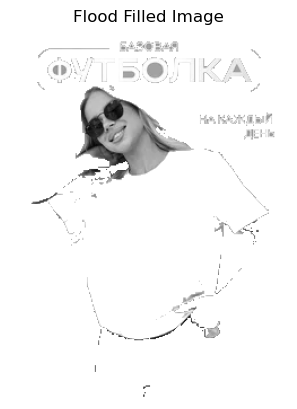

In [3]:

#url = 'https://basket-14.wbbasket.ru/vol2092/part209231/209231530/images/c246x328/1.webp'  # Замените на реальный URL вашего изображения

import cv2
import numpy as np
import requests
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt

# URL
url = 'https://basket-14.wbbasket.ru/vol2092/part209231/209231530/images/c246x328/1.webp'   # Замените на вашу ссылку

# Загрузка 
response = requests.get(url)
img = Image.open(BytesIO(response.content))
gray = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)

h, w = gray.shape

# Создаем маску для floodFill на 2 пикселя больше
mask = np.zeros((h + 2, w + 2), np.uint8)

# Значение для заливки (например, белый цвет)
fill_value = 255

# Порог изменения тона
tolerance = 10

# Функции для заливки по границе
def fill_border():
    for row in range(h):
        if mask[row + 1, 1] == 0:  # Левая граница
            cv2.floodFill(gray, mask, (0, row), fill_value, loDiff=(tolerance,), upDiff=(tolerance,))
        if mask[row + 1, w] == 0:  # Правая граница
            cv2.floodFill(gray, mask, (w - 1, row), fill_value, loDiff=(tolerance,), upDiff=(tolerance,))

    for col in range(w):
        if mask[1, col + 1] == 0:  # Верхняя граница
            cv2.floodFill(gray, mask, (col, 0), fill_value, loDiff=(tolerance,), upDiff=(tolerance,))
        if mask[h, col + 1] == 0:  # Нижняя граница
            cv2.floodFill(gray, mask, (col, h - 1), fill_value, loDiff=(tolerance,), upDiff=(tolerance,))

# Выполняем заливку по границам
fill_border()

# Показываем результат с помощью Matplotlib
plt.imshow(gray, cmap='gray')
plt.title('Flood Filled Image')
plt.axis('off')  # Отключаем оси для более чистого вида
plt.show()


0: 640x480 1 refrigerator, 54.0ms
Speed: 1.4ms preprocess, 54.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)
Площадь бокса: 47672 пикселей
Общая площадь изображения: 80688 пикселей
Отношение площадей: 0.5908 (59.08%)


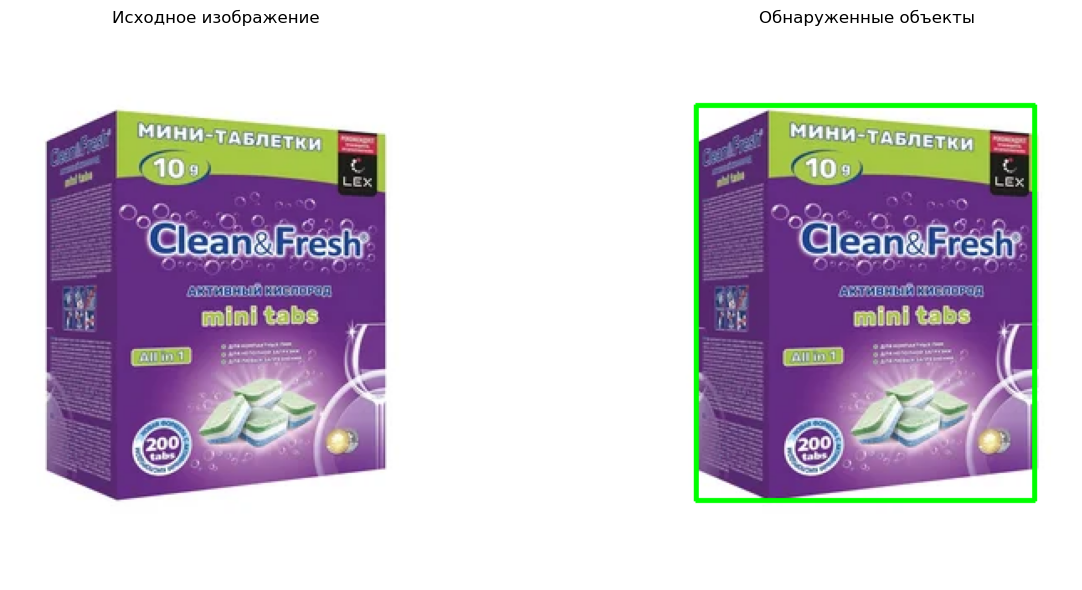

In [9]:
import cv2
import numpy as np
from urllib.request import urlopen
import matplotlib.pyplot as plt
from ultralytics import YOLO
%matplotlib inline

def detect_and_draw_boxes(image_url):
    # Загрузка изображения
    resp = urlopen(image_url)
    image_array = np.asarray(bytearray(resp.read()), dtype=np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Загрузка модели YOLO
    # model = YOLO('yolov8x.pt')  # nano model
    model = YOLO('yolov8n.pt') 
    # Получение результатов
    results = model(image_rgb)

    # Получение размеров изображения
    total_image_area = image_rgb.shape[0] * image_rgb.shape[1]

    # Создание копии изображения для рисования
    image_with_boxes = image_rgb.copy()
    
    # Переменная для хранения площадей боксов
    box_areas = []

    # Переменная для хранения центроидов боксов
    keypoints = []
    
    # Рисование боксов
    for result in results:
        boxes = result.boxes.cpu().numpy()
        for box in boxes:
            # Получение координат
            x1, y1, x2, y2 = box.xyxy[0].astype(int)

            # Вычисление площади бокса
            box_area = (x2 - x1) * (y2 - y1)
            box_areas.append(box_area)
            
            # Вычисление отношения площадей
            area_ratio = box_area / total_image_area

            # Вычисление центроида бокса
            cx = (x1 + x2) / 2
            cy = (y1 + y2) / 2
            keypoints.append((cx, cy))
            
            # Рисование рамки
            cv2.rectangle(
                image_with_boxes,
                (x1, y1),
                (x2, y2),
                (0, 255, 0),  # Зеленый цвет
                2  # Толщина линии
            )
            
            print(f"Площадь бокса: {box_area} пикселей")
            print(f"Общая площадь изображения: {total_image_area} пикселей")
            print(f"Отношение площадей: {area_ratio:.4f} ({area_ratio*100:.2f}%)")
    
    # Отображение результатов
    plt.figure(figsize=(15, 6))
    
    # Исходное изображение
    plt.subplot(121)
    plt.imshow(image_rgb)
    plt.title('Исходное изображение')
    plt.axis('off')
    
    # Изображение с боксами
    plt.subplot(122)
    plt.imshow(image_with_boxes)
    plt.title('Обнаруженные объекты')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return box_area, total_image_area, keypoints

# Пример использования
#image_url ='https://basket-14.wbbasket.ru/vol2092/part209231/209231530/images/c246x328/1.webp'
#image_url ='https://basket-10.wbbasket.ru/vol1562/part156271/156271233/images/c246x328/1.webp'
image_url = 'https://basket-17.wbbasket.ru/vol2796/part279619/279619038/images/c246x328/1.webp'

box_area, total_area, keypoints = detect_and_draw_boxes(image_url)


Энтропия изображения: 6.50
Доля объекта в зонах правила третей: 8.98%


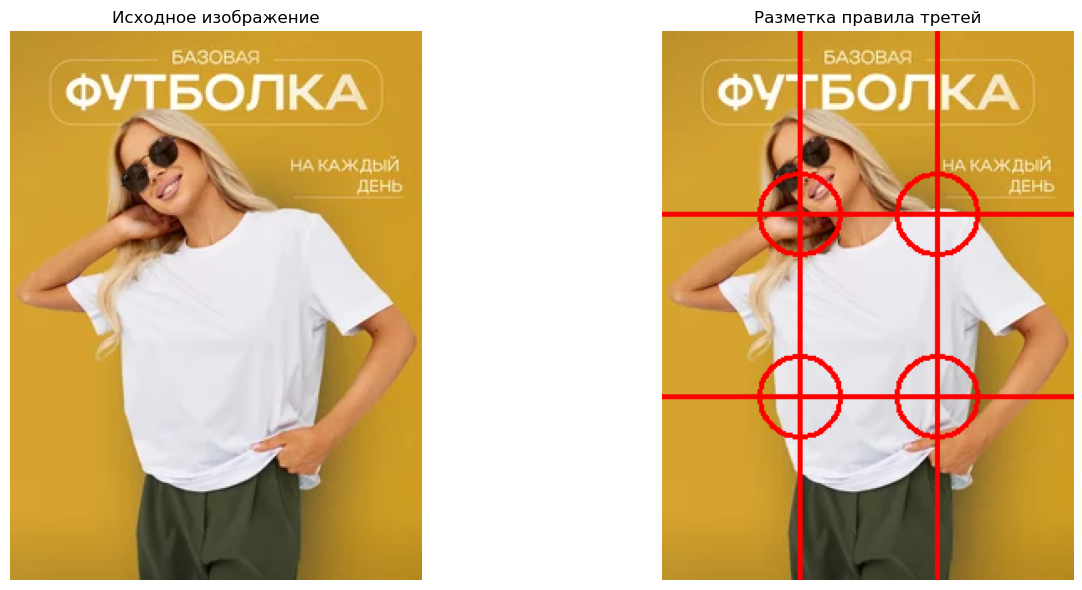

In [30]:
import numpy as np
import cv2
from scipy.stats import entropy
from urllib.request import urlopen
import matplotlib.pyplot as plt
%matplotlib inline

def display_image_with_thirds(image_url):
    # Загрузка изображения
    resp = urlopen(image_url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Конвертация из BGR в RGB
    
    # Создание копии для разметки
    marked_image = image.copy()
    height, width = image.shape[:2]
    
    # Рисование линий правила третей
    h_lines = [height // 3, (height * 2) // 3]
    v_lines = [width // 3, (width * 2) // 3]
    
    # Рисование горизонтальных линий
    for h in h_lines:
        cv2.line(marked_image, (0, h), (width, h), (255, 0, 0), 2)
    
    # Рисование вертикальных линий
    for v in v_lines:
        cv2.line(marked_image, (v, 0), (v, height), (255, 0, 0), 2)
    
    # Отображение точек пересечения
    margin = min(height, width) // 10
    for h in h_lines:
        for v in v_lines:
            cv2.circle(marked_image, (v, h), margin, (255, 0, 0), 2)
    
    # Создание фигуры с двумя изображениями
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Исходное изображение
    ax1.imshow(image)
    ax1.set_title('Исходное изображение')
    ax1.axis('off')
    
    # Изображение с разметкой
    ax2.imshow(marked_image)
    ax2.set_title('Разметка правила третей')
    ax2.axis('off')
    
    plt.tight_layout()
    return fig

def calculate_entropy(image_url):
    # Загрузка изображения по URL
    resp = urlopen(image_url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_GRAYSCALE)
    
    # Расчет гистограммы
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    
    # Нормализация гистограммы для получения вероятностей
    hist = hist.ravel() / hist.sum()
    
    # Удаление нулевых вероятностей
    hist = hist[hist != 0]
    
    # Расчет энтропии
    entropy_value = -np.sum(hist * np.log2(hist))
    
    return entropy_value

def calculate_rule_of_thirds(image_url):
    # Загрузка изображения
    resp = urlopen(image_url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    
    height, width = image.shape[:2]
    
    # Определение линий правила третей
    h_lines = [height // 3, (height * 2) // 3]
    v_lines = [width // 3, (width * 2) // 3]
    
    # Создание маски для областей правила третей
    rot_mask = np.zeros((height, width), dtype=np.uint8)
    
    # Определение зон интереса (области вокруг точек пересечения)
    margin = min(height, width) // 10
    
    for h in h_lines:
        for v in v_lines:
            cv2.circle(rot_mask, (v, h), margin, 255, -1)
    
    # Бинаризация изображения для выделения объекта
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    
    # Подсчет пикселей объекта в зонах RoT
    object_pixels_in_rot = np.sum((binary > 0) & (rot_mask > 0))
    
    # Расчет доли объекта в зонах RoT
    if box_area > 0:
        rot_ratio = object_pixels_in_rot / box_area
    else:
        rot_ratio = 0
    
    return rot_ratio

# Пример использования
image_url ='https://basket-14.wbbasket.ru/vol2092/part209231/209231530/images/c246x328/1.webp'
#image_url = 'https://basket-17.wbbasket.ru/vol2796/part279619/279619038/images/c246x328/1.webp'

# Отображение изображений
display_image_with_thirds(image_url)

# Расчет метрик
entropy_value = calculate_entropy(image_url)
rot_ratio = calculate_rule_of_thirds(image_url)

print(f"Энтропия изображения: {entropy_value:.2f}")
print(f"Доля объекта в зонах правила третей: {rot_ratio:.2%}")

In [2]:
!pip install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 4.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.1/279.1 kB 5.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 4.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.2/253.2 kB 7.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.1 MB/s eta 0:00:00a 0:00:01


Количество предполагаемых текстовых областей: 4
Обнаруженный текст: 'БАЗОВАЯ' | Количество символов: 7
Обнаруженный текст: 'ФУТБОЛКА' | Количество символов: 8
Обнаруженный текст: 'HА КАЖДЫЙ' | Количество символов: 9
Обнаруженный текст: 'ДЕНЬ' | Количество символов: 4


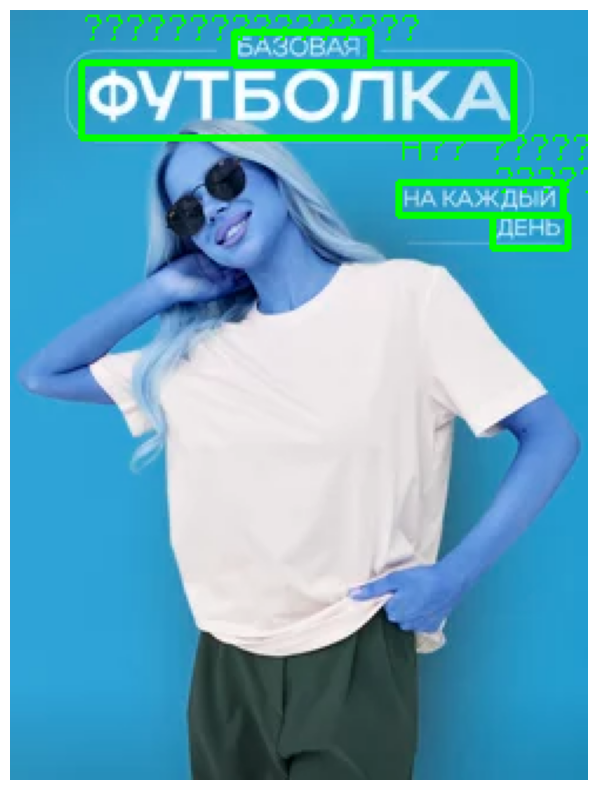

{'has_text': True, 'text_regions': 4}


In [13]:
import requests
from io import BytesIO
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import easyocr
import cv2

def detect_text_with_easyocr(image_url):
    try:
        # Скачиваем изображение
        response = requests.get(image_url)
        response.raise_for_status()
        image = np.array(Image.open(BytesIO(response.content)))

        # Создаем объект для распознавания текста
        reader = easyocr.Reader(['ru', 'en'])  # Укажите языки, которые хотите использовать

        # Распознаем текст на изображении
        results = reader.readtext(image)

        # Проверяем, найден ли текст
        if results:
            print(f"Количество предполагаемых текстовых областей: {len(results)}")

            # Рисуем прямоугольники вокруг обнаруженных областей текста
            for (bbox, text, prob) in results:
                (top_left, top_right, bottom_right, bottom_left) = bbox
                top_left = tuple(map(int, top_left))
                bottom_right = tuple(map(int, bottom_right))
                cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)  # Зеленый цвет

                # Добавляем текст над прямоугольником
                cv2.putText(image, text, (top_left[0], top_left[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

                # Подсчет символов
                char_count = len(text)
                print(f"Обнаруженный текст: '{text}' | Количество символов: {char_count}")

            plt.figure(figsize=(10, 10))
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.axis('off') 
            plt.show()

            return {"has_text": True, "text_regions": len(results)}
        else:
            print("Текст не найден.")
            return {"has_text": False, "text_regions": 0}
    except Exception as e:
        print(f"Ошибка: {e}")
        return {"error": str(e)}

image_url = 'https://basket-14.wbbasket.ru/vol2092/part209231/209231530/images/c246x328/1.webp'  
result = detect_text_with_easyocr(image_url)
print(result)

In [36]:
import cv2
import numpy as np
from urllib.request import urlopen

def compute_normalized_distances_to_thirds(image, keypoints):
    height, width = image.shape[:2]
    
    # Вычисление координат линий третей
    third_x1, third_x2 = width / 3, 2 * width / 3
    third_y1, third_y2 = height / 3, 2 * height / 3
    
    normalized_vertical_distances = []
    normalized_horizontal_distances = []
    
    # Вычисление нормализованных расстояний до ближайшей вертикальной и горизонтальной линии третей
    for (x, y) in keypoints:
        # Расстояния до вертикальных линий
        vertical_distances = [abs(x - third_x1), abs(x - third_x2)]
        min_vertical_distance = min(vertical_distances)
        normalized_vertical_distance = min_vertical_distance / width
        
        # Расстояния до горизонтальных линий
        horizontal_distances = [abs(y - third_y1), abs(y - third_y2)]
        min_horizontal_distance = min(horizontal_distances)
        normalized_horizontal_distance = min_horizontal_distance / height
        
        normalized_vertical_distances.append(normalized_vertical_distance)
        normalized_horizontal_distances.append(normalized_horizontal_distance)
    
    average_normalized_vertical_distance = np.mean(normalized_vertical_distances)
    average_normalized_horizontal_distance = np.mean(normalized_horizontal_distances)
    
    return average_normalized_vertical_distance, average_normalized_horizontal_distance

# Пример использования
image_url = 'https://basket-14.wbbasket.ru/vol2092/part209231/209231530/images/c246x328/1.webp'
resp = urlopen(image_url)
image_array = np.asarray(bytearray(resp.read()), dtype=np.uint8)
image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

avg_norm_vert_dist, avg_norm_horiz_dist = compute_normalized_distances_to_thirds(image, keypoints)
print(f'Average normalized distance to vertical thirds: {avg_norm_vert_dist:.4f}')
print(f'Average normalized distance to horizontal thirds: {avg_norm_horiz_dist:.4f}')

Average normalized distance to vertical thirds: 0.1585
Average normalized distance to horizontal thirds: 0.1072


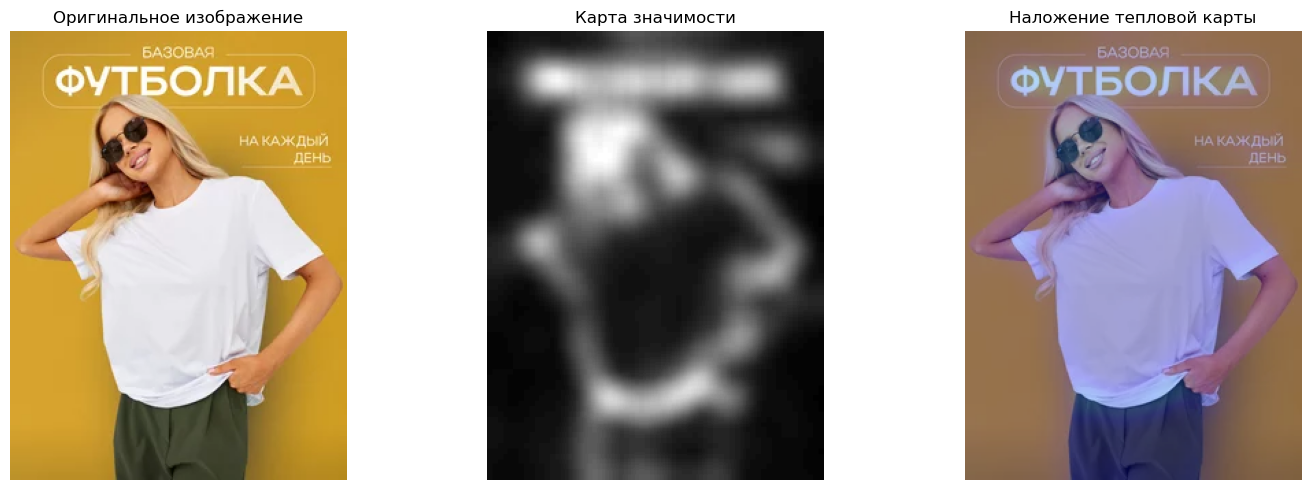

In [18]:
import numpy as np
import cv2
from urllib.request import urlopen
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2
%matplotlib inline

def spectral_residual_saliency(image_url):
    # Загрузка изображения
    resp = urlopen(image_url)
    image_array = np.asarray(bytearray(resp.read()), dtype=np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
    
    # Преобразование в оттенки серого
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Изменение размера для ускорения вычислений (как в оригинальной статье)
    height, width = gray.shape
    size = min(height, width)
    scale = 64 / size  # размер 64 пикселя по минимальной стороне
    scaled_width = int(width * scale)
    scaled_height = int(height * scale)
    gray = cv2.resize(gray, (scaled_width, scaled_height))
    
    # Преобразование в float и нормализация
    gray = gray.astype(np.float32) / 255.0
    
    # Применение FFT
    freq = fft2(gray)
    magnitude = np.abs(freq)
    phase = np.angle(freq)
    
    # Вычисление логарифма амплитуды
    log_magnitude = np.log(magnitude + 1e-8)
    
    # Вычисление среднего логарифма амплитуды (spectral residual)
    kernel_size = 3
    mean_log_magnitude = cv2.blur(log_magnitude, (kernel_size, kernel_size))
    spectral_residual = log_magnitude - mean_log_magnitude
    
    # Восстановление изображения
    exp_spectral_residual = np.exp(spectral_residual)
    real_part = exp_spectral_residual * np.cos(phase)
    imag_part = exp_spectral_residual * np.sin(phase)
    freq_residual = real_part + 1j * imag_part
    
    # Обратное FFT
    saliency_map = np.abs(ifft2(freq_residual))
    
    # Пост-обработка
    saliency_map = (saliency_map - np.min(saliency_map)) / (np.max(saliency_map) - np.min(saliency_map))
    saliency_map = cv2.GaussianBlur(saliency_map, (9, 9), 2.5)
    saliency_map = (saliency_map * 255).astype(np.uint8)
    
    # Изменение размера обратно к оригинальному
    saliency_map = cv2.resize(saliency_map, (width, height))
    
    # Создание тепловой карты
    heatmap = cv2.applyColorMap(saliency_map, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    # Наложение тепловой карты на оригинальное изображение
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    overlay = cv2.addWeighted(image_rgb, 0.7, heatmap, 0.3, 0)
    
    # Визуализация результатов
    plt.figure(figsize=(15, 5))
    
    # Оригинальное изображение
    plt.subplot(131)
    plt.imshow(image_rgb)
    plt.title('Оригинальное изображение')
    plt.axis('off')
    
    # Карта значимости в оттенках серого
    plt.subplot(132)
    plt.imshow(saliency_map, cmap='gray')
    plt.title('Карта значимости')
    plt.axis('off')
    
    # Наложение тепловой карты
    plt.subplot(133)
    plt.imshow(overlay)
    plt.title('Наложение тепловой карты')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return saliency_map, heatmap, overlay

# Пример использования
image_url = 'https://basket-14.wbbasket.ru/vol2092/part209231/209231530/images/c246x328/1.webp'
#image_url = 'https://basket-17.wbbasket.ru/vol2796/part279619/279619038/images/c246x328/1.webp'
saliency_map, heatmap, overlay = spectral_residual_saliency(image_url)

АНАЛИЗ ИЗОБРАЖЕНИЯ:
--------------------------------------------------
1. Энтропия изображения: 4.96
   Средняя энтропия: нормальное количество деталей

2. Соответствие правилу третей: 4.9%
   Объект практически не соответствует правилу третей
   Пиксели в зонах RoT: 2572
   Всего пикселей объекта: 52011
--------------------------------------------------


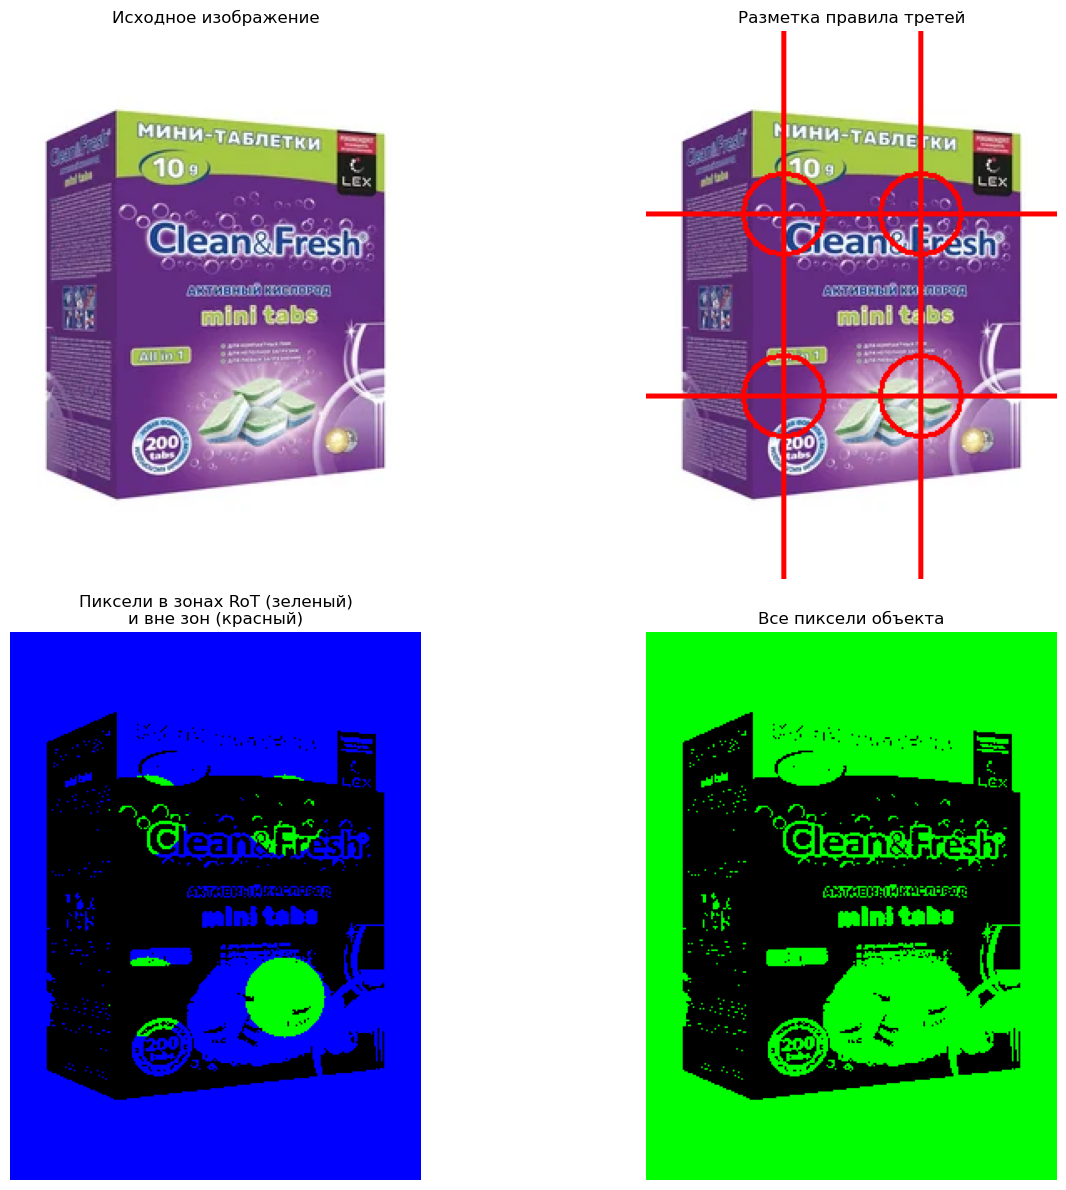

In [5]:
import numpy as np
import cv2
from scipy.stats import entropy
from urllib.request import urlopen
import matplotlib.pyplot as plt
%matplotlib inline

def display_full_analysis(image_url):
    # Загрузка изображения
    resp = urlopen(image_url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    height, width = image.shape[:2]
    
    # Создание маски для областей правила третей
    rot_mask = np.zeros((height, width), dtype=np.uint8)
    
    # Определение линий правила третей
    h_lines = [height // 3, (height * 2) // 3]
    v_lines = [width // 3, (width * 2) // 3]
    
    # Определение зон интереса
    margin = min(height, width) // 10
    for h in h_lines:
        for v in v_lines:
            cv2.circle(rot_mask, (v, h), margin, 255, -1)
    
    # Бинаризация изображения
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    
    # Создание визуализации для числителя (пиксели в зонах RoT)
    numerator_vis = np.zeros_like(image_rgb)
    numerator_vis[binary > 0] = [0, 0, 255]  # Красный цвет для всех пикселей объекта
    numerator_vis[(binary > 0) & (rot_mask > 0)] = [0, 255, 0]  # Зеленый цвет для пикселей в RoT
    
    # Создание визуализации для знаменателя (все пиксели объекта)
    denominator_vis = np.zeros_like(image_rgb)
    denominator_vis[binary > 0] = [0, 255, 0]  # Зеленый цвет для всех пикселей объекта
    
    # Создание разметки правила третей
    marked_image = image_rgb.copy()
    for h in h_lines:
        cv2.line(marked_image, (0, h), (width, h), (255, 0, 0), 2)
    for v in v_lines:
        cv2.line(marked_image, (v, 0), (v, height), (255, 0, 0), 2)
    for h in h_lines:
        for v in v_lines:
            cv2.circle(marked_image, (v, h), margin, (255, 0, 0), 2)
    
    # Расчет метрик
    object_pixels_in_rot = np.sum((binary > 0) & (rot_mask > 0))
    total_object_pixels = np.sum(binary > 0)
    rot_ratio = object_pixels_in_rot / total_object_pixels if total_object_pixels > 0 else 0
    entropy_value = calculate_entropy(image_url)
    
    # Создание визуализации
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Исходное изображение
    axes[0,0].imshow(image_rgb)
    axes[0,0].set_title('Исходное изображение')
    axes[0,0].axis('off')
    
    # Изображение с разметкой
    axes[0,1].imshow(marked_image)
    axes[0,1].set_title('Разметка правила третей')
    axes[0,1].axis('off')
    
    # Визуализация числителя
    axes[1,0].imshow(numerator_vis)
    axes[1,0].set_title('Пиксели в зонах RoT (зеленый)\nи вне зон (красный)')
    axes[1,0].axis('off')
    
    # Визуализация знаменателя
    axes[1,1].imshow(denominator_vis)
    axes[1,1].set_title('Все пиксели объекта')
    axes[1,1].axis('off')
    
    plt.tight_layout()
    
    # Вывод метрик
    print("АНАЛИЗ ИЗОБРАЖЕНИЯ:")
    print("-" * 50)
    print(f"1. Энтропия изображения: {entropy_value:.2f}")
    print(f"   {interpret_entropy(entropy_value)}")
    print()
    print(f"2. Соответствие правилу третей: {rot_ratio:.1%}")
    print(f"   {interpret_rot_ratio(rot_ratio)}")
    print(f"   Пиксели в зонах RoT: {object_pixels_in_rot}")
    print(f"   Всего пикселей объекта: {total_object_pixels}")
    print("-" * 50)

def interpret_entropy(entropy_value):
    if entropy_value < 1:
        return "Очень низкая энтропия: изображение почти монотонное, мало деталей"
    elif entropy_value < 3:
        return "Низкая энтропия: изображение простое, мало вариаций"
    elif entropy_value < 5:
        return "Средняя энтропия: нормальное количество деталей"
    elif entropy_value < 7:
        return "Высокая энтропия: много деталей и текстур"
    else:
        return "Очень высокая энтропия: изображение сложное, много мелких деталей"

def interpret_rot_ratio(rot_ratio):
    if rot_ratio < 0.2:
        return "Объект практически не соответствует правилу третей"
    elif rot_ratio < 0.4:
        return "Слабое соответствие правилу третей"
    elif rot_ratio < 0.6:
        return "Среднее соответствие правилу третей"
    elif rot_ratio < 0.8:
        return "Хорошее соответствие правилу третей"
    else:
        return "Отличное соответствие правилу третей"

def calculate_entropy(image_url):
    resp = urlopen(image_url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_GRAYSCALE)
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist = hist.ravel() / hist.sum()
    hist = hist[hist != 0]
    return -np.sum(hist * np.log2(hist))

# Пример использования
image_url = 'https://basket-17.wbbasket.ru/vol2796/part279619/279619038/images/c246x328/1.webp'
display_full_analysis(image_url)

In [5]:
# Сохраняем объединенные данные в новый файл CSV
output_path = '/Users/anastasia/Desktop/Научные страдания/Данные/Data_full.csv'
df.to_csv(output_path, index=False, sep=';', encoding='utf-8-sig')

print("Объединение файлов CSV завершено. Результат сохранен в:", output_path)

,Thumb,H_mean,S_mean,L_mean,Contrast,Person_probability,Area_ratio,Entropy_value,RoT_vert,RoT_horiz
0,https://basket-14.wbbasket.ru/vol2185/part2185...,72.250954,84.311186,123.789560,0.192690,0,0.855109,7.203392,0.136179,0.165142
1,https://basket-10.wbbasket.ru/vol1524/part1524...,77.452657,39.116387,184.336568,0.200213,1,0.722598,6.185410,0.132114,0.125508
2,https://basket-10.wbbasket.ru/vol1553/part1553...,103.772593,43.222697,144.353250,0.163073,0,0.802424,6.793059,0.081301,0.165142
3,https://basket-10.wbbasket.ru/vol1333/part1333...,96.851812,40.173198,158.710465,0.158313,0,0.406702,7.087378,0.154472,0.146850
4,https://basket-15.wbbasket.ru/vol2262/part2262...,83.612334,28.000297,133.170447,0.201946,0,0.960477,7.122914,0.156504,0.165142
...,...,...,...,...,...,...,...,...,...,...
54256,https://basket-16.wbbasket.ru/vol2497/part2497...,53.355158,41.566069,79.616498,0.237750,0,0.974680,7.218429,0.126887,0.051902
54257,https://basket-14.wbbasket.ru/vol2048/part2048...,106.567668,168.031851,84.897506,0.268826,0,0.391694,7.142467,0.010163,0.076728
54258,https://basket-13.wbbasket.ru/vol2035/part2035...,44.757944,42.641570,76.866610,0.236689,0,0.249665,7.258437,0.146341,0.061789
54259,https://basket-14.wbbasket.ru/vol2048/part2048...,103.545360,171.674648,58.237198,0.256369,0,0.422616,7.025155,0.029472,0.114837
